In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import imageio

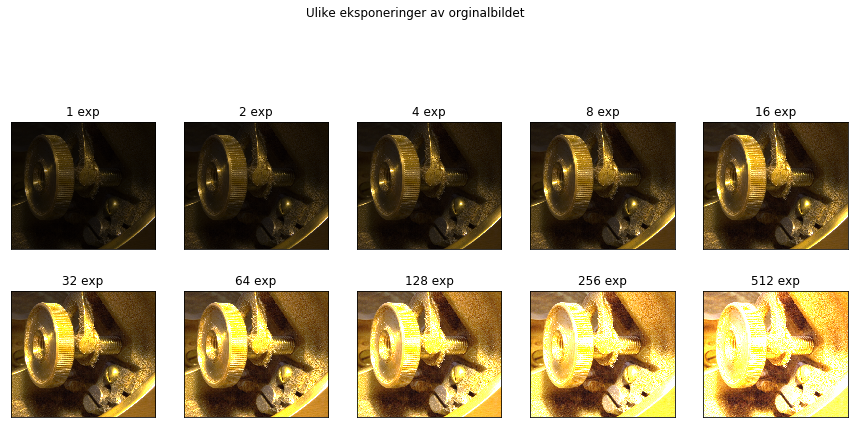

In [2]:
N = 10
dT = 2 ** np.arange(N)
exs = np.array([imageio.imread('ressurser/Adjuster/Adjuster_{:05}.png'.format(dt)) for dt in dT])

fig = plt.figure(figsize=(15, 15))  # figure size in inches
fig.suptitle("Ulike eksponeringer av orginalbildet")

for i, (dt, imge) in enumerate(zip(dT, exs)):
    ax = fig.add_subplot(N // 2, (N + 1) // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(imge, plt.cm.gray)
    ax.set_title('%d exp' % dt)

In [3]:
# "Dum" nedskalering for å kunne gjennmføre rekonstruere responskurven
print(exs.shape)
low_exs = exs[:,::50,::50,:]
print(low_exs.shape)

(10, 678, 775, 3)
(10, 14, 16, 3)


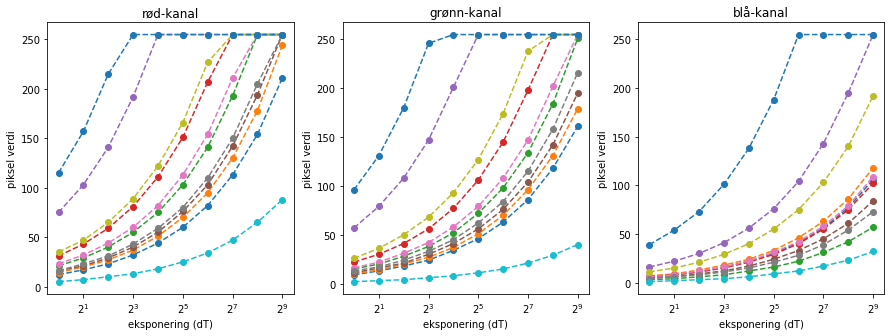

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for color, ax in zip(['rød', 'grønn', 'blå'], axs):
    ax.set_xlabel('eksponering (dT)')
    ax.set_ylabel('piksel verdi')
    ax.set_title('%s-kanal' % color)
    ax.set_xscale('log', basex=2)

for img in low_exs.reshape(10, -1, 3).transpose(1, 2, 0)[::(low_exs.shape[1] * low_exs.shape[2]) // 10]:
    for i, eksps in enumerate(img):
        axs[i].plot(dT, eksps, 'o--')

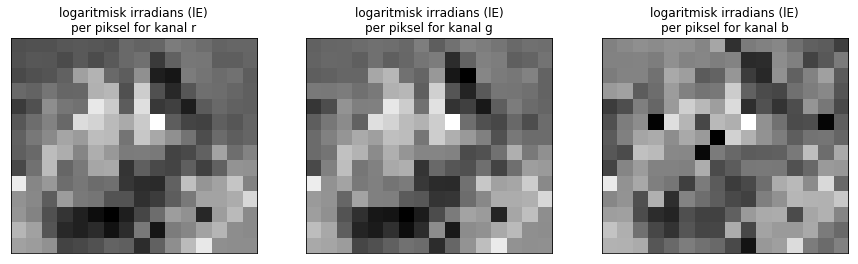

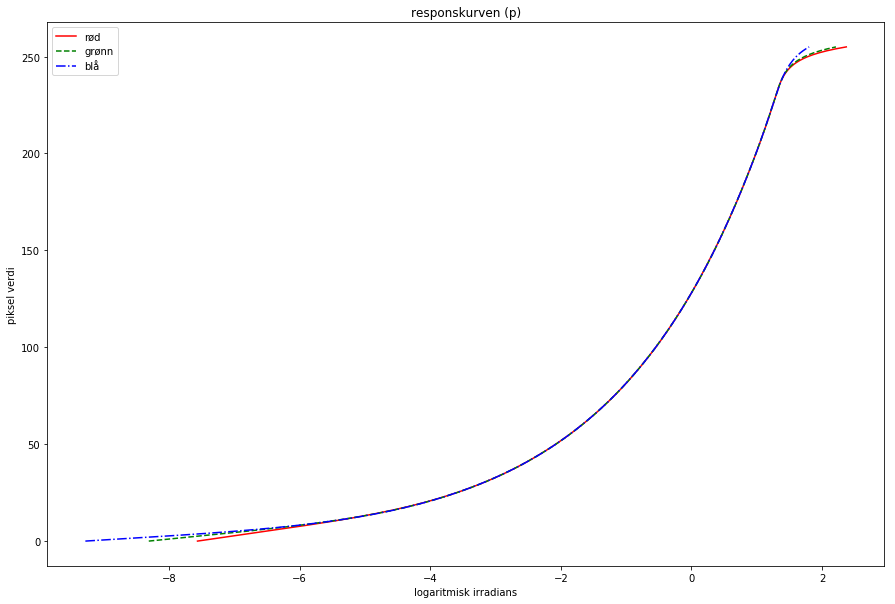

In [5]:
from hdrie.rekonstruksjon import debevec_maliks

responskurver = [debevec_maliks(low_chan, dT, 40, 256) for low_chan in low_exs.transpose(3, 0, 1, 2)]
kanaler = [('r', '-'), ('g', '--'), ('b', '-.')]

fig_irr = plt.figure(figsize=(15, 10))  # figure size in inches
fig_p = plt.figure(figsize=(15,10))
ax_p = fig_p.add_subplot(1, 1, 1)

for i, ((color, shape), (p, lE)) in enumerate(zip(kanaler, responskurver)):
    ax_irr = fig_irr.add_subplot(1, 3, i + 1, xticks=[], yticks=[])
    ax_irr.imshow(lE, plt.cm.gray)
    ax_irr.set_title('logaritmisk irradians (lE)\nper piksel for kanal %s' % (color))

    ax_p.plot(p, np.arange(256), color + shape)
    
ax_p.set_title('responskurven (p)')
ax_p.set_ylabel('piksel verdi')
ax_p.set_xlabel('logaritmisk irradians')
ax_p.legend(['rød', 'grønn', 'blå'])

In [6]:
from hdrie.rekonstruksjon import rekonstruer_irradians

ps = np.array([p for p, _ in responskurver])

n_exs = exs.transpose(3, 0, 1, 2)

lEs = []
for kanal, p in zip(n_exs, ps):
    lEs.append(rekonstruer_irradians(kanal, dT, p, 256))
    
lEs = np.array(lEs)
lEs = lEs.transpose(1, 2, 0)

In [7]:
exr_img = imageio.imread('ressurser/Adjuster/Adjuster.exr', format='EXR-FI')
print("Forventet: ", exr_img.min(), exr_img.max(), abs(exr_img.max() / exr_img.min()))

expt = exr_img - exr_img.min()
expt = expt / expt.max()

kons = np.exp(lEs)
print("Rekonstruert: ", kons.min(), kons.max(), abs(kons.max() / kons.min()))

kons = kons - kons.min()
kons = kons / kons.max()

imageio.freeimage warning: Warning: converting color model B/G/R/left.B/left.G/left.R/right.B/right.G/right.R to RGB color model


Forventet:  -1.6450882e-05 12.0 729444.2
Rekonstruert:  2.767192484058784e-06 1.8586415063763961 671670.4808514913


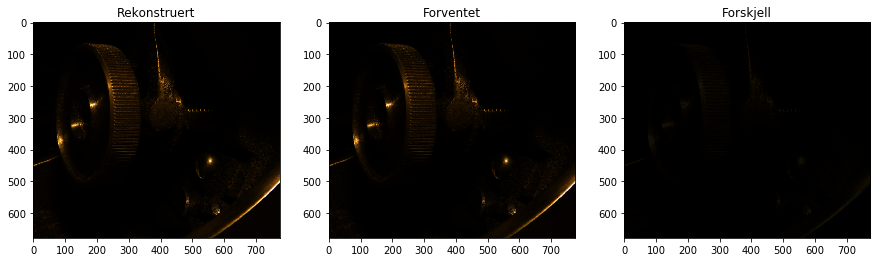

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

axs[0].set_title('Rekonstruert')
axs[0].imshow(kons)
axs[1].set_title('Forventet')
axs[1].imshow(expt)
axs[2].set_title('Forskjell')
axs[2].imshow(np.abs(kons - expt))